# Create dataframe including the slope of the glacier

In [9]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_bed_surf_elev.csv')

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Convert surge value to have only surge/non-surge glacier

In [16]:
def convert_surge(surge_value):
    """
    Surging
    The Surging attribute contains information on evidence for surging, and
    is based on the inventory of Sevestre and Benn (2015).

    Value Surging
    0 No evidence
    1 Possible
    2 Probable
    3 Observed
    9 Not assigned
    
    We convert 1,2,3 to surgetype and 0,9 to not surgetype
    """
    surgetype = {0:0, 1:1, 2:1, 3:1, 9:0}
    return surgetype[surge_value]

df['surgetype'] = df.Surge.apply(convert_surge)

### Drop all the rows that are outside of the glacier

In [4]:
df.dropna(subset=['thickness', 'bed'], inplace=True)

# drop all glaciers that already melted away (<1 sq km)
df = df[df.Area > 1].copy()

### Drop all glaciers shorter than 1km

In [5]:
df = df[df.Lmax > 1000].copy()

### Drop all glaciers that already melted away (<1 sq km)

In [6]:
df = df[df.Area > 1].copy()

In [7]:
df.describe()

,Unnamed: 0,x,y,Surge,BgnDate,EndDate,CenLon,CenLat,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Linkages,bed,thickness,surface_elevation
count,93918.000000,93918.000000,9.391800e+04,93918.000000,9.391800e+04,9.391800e+04,93918.000000,93918.000000,93918.000000,93918.000000,...,93918.000000,93918.000000,93918.0,93918.0,93918.0,93918.000000,93918.000000,93918.000000,93918.000000,93918.000000
mean,64751.804329,535546.623089,8.728605e+06,0.548159,2.006714e+07,-9.951029e+06,16.597977,78.605143,50.126481,193.498158,...,174.690879,9013.096978,0.0,0.0,0.0,0.155785,6.503822,346.765451,88.648832,435.414283
std,37950.820919,71863.205901,9.562094e+04,1.017305,2.225149e+04,1.212296e+06,3.364339,0.850161,138.249861,142.275509,...,116.754569,10054.495089,0.0,0.0,0.0,0.362653,4.012516,251.052591,90.278247,230.262506
min,206.000000,408107.316981,8.503823e+06,0.000000,2.001071e+07,-9.999999e+06,10.813900,76.618700,1.001000,0.000000,...,1.000000,1047.000000,0.0,0.0,0.0,0.000000,0.000000,-649.982800,0.010668,0.012352
25%,32075.250000,489380.028635,8.652802e+06,0.000000,2.005072e+07,-9.999999e+06,14.480900,77.911900,2.514000,85.000000,...,62.000000,3024.000000,0.0,0.0,0.0,0.000000,0.000000,163.805460,30.288260,267.561040
50%,64583.500000,528417.366548,8.732265e+06,0.000000,2.008061e+07,-9.999999e+06,16.225700,78.654400,6.845000,155.000000,...,169.000000,4996.000000,0.0,0.0,0.0,0.000000,9.000000,313.674125,60.983154,405.404720
75%,97002.750000,569041.958837,8.807497e+06,1.000000,2.008090e+07,-9.999999e+06,18.099300,79.327100,30.809000,289.000000,...,288.000000,10800.000000,0.0,0.0,0.0,0.000000,9.000000,497.751920,110.639390,567.570613
max,130988.000000,841688.293748,8.952002e+06,3.000000,2.010072e+07,2.006000e+07,32.470600,80.452500,1226.367000,789.000000,...,359.000000,69637.000000,0.0,0.0,0.0,1.000000,9.000000,1649.086500,1307.982800,1677.679600


# Defining the window lenght and so the bed/surf slope of the window

### Test on one glacier

In [11]:
data = df[df.rgiid=='RGI60-07.00004']
# gb = data.groupby(data.index // (data.shape[0]/10)).mean()
gb = data.groupby(data.index // (data.shape[0]/10))
start = gb.head(1)
end = gb.tail(1)
thick = abs(start.thickness.values - end.thickness.values)

# window_length = np.sqrt((start.x.values[0] - end.x.values[0])**2 + (start.y.values[0] - end.y.values[0])**2)
window_length = np.sqrt((start.x.values - end.x.values)**2 + (start.y.values - end.y.values)**2)
slope = np.arctan(thick/window_length)
data.columns

Index(['Unnamed: 0', 'rgiid', 'x', 'y', 'Surge', 'BgnDate', 'EndDate',
       'CenLon', 'CenLat', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect',
       'Lmax', 'Status', 'Connect', 'Form', 'TermType', 'Linkages', 'Name',
       'check_geom', 'geometry', 'bed', 'thickness', 'surface_elevation'],
      dtype='object')

### Defining the function to apply it to all the glaciers

In [12]:
def get_slope(data, n_windows=10):
    gb = data.groupby(data.index // (data.shape[0]/n_windows))
    start = gb.head(1)
    end = gb.tail(1)
#     thick = abs(start.thickness.values - end.thickness.values)
    thick_mean = (start.thickness.values + end.thickness.values)/2
    
#     bed = end.bed.values - start.bed.values
    bed = start.bed.values - end.bed.values
    surf = start.surface_elevation.values - end.surface_elevation.values
    
    window_length = np.sqrt((start.x.values - end.x.values)**2 + (start.y.values - end.y.values)**2)
#     if window_length.min() == 0:
#         print(start.x.values, end.x.values, start.y.values, end.y.values, window_length)
#         print(start.rgiid.unique())
#     bed_slope = np.arctan(thick/window_length)
    bed_slope = np.arctan(bed/window_length)
    surf_slope = np.arctan(surf/window_length)
    
    print(data.rgiid.unique()[0], surf_slope.shape, surf_slope.shape)
    
    return {
        'window_length':window_length
        , 'bed_slope':bed_slope
        , 'thick_mean':thick_mean
        , 'surf_slope':surf_slope
        , 'window_id':np.arange(0, surf_slope.shape[0], 1)
    }

get_slope(df[df.rgiid=='RGI60-07.00006'])

RGI60-07.00006 (11,) (11,)


{'window_length': array([175.36547802, 834.13861589, 667.77128187, 623.10231438,
        558.00895542, 623.10226284, 623.10218563, 693.19192192,
        834.13736943, 670.64239358, 472.18468741]),
 'bed_slope': array([ 0.14748393,  0.1859458 ,  0.13032663, -0.07252574,  0.05251223,
         0.06832962,  0.07966501,  0.06920212,  0.04376985,  0.08497454,
         0.15272773]),
 'thick_mean': array([24.0349315, 41.583219 , 89.191565 , 84.31863  , 51.34808  ,
        45.334068 , 45.027788 , 53.622568 , 52.643334 , 46.47258  ,
        50.801445 ]),
 'surf_slope': array([0.15276461, 0.14640248, 0.05833696, 0.02086032, 0.06621026,
        0.07528647, 0.07369049, 0.05332567, 0.05509099, 0.08922889,
        0.12847518]),
 'window_id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

### Get the number of window per glaciers

In [13]:
sloped = df.groupby('rgiid').apply(get_slope)

RGI60-07.00004 (10,) (10,)
RGI60-07.00006 (11,) (11,)
RGI60-07.00008 (11,) (11,)
RGI60-07.00010 (11,) (11,)
RGI60-07.00024 (11,) (11,)
RGI60-07.00025 (11,) (11,)
RGI60-07.00026 (11,) (11,)
RGI60-07.00027 (11,) (11,)
RGI60-07.00028 (11,) (11,)
RGI60-07.00029 (11,) (11,)
RGI60-07.00030 (11,) (11,)
RGI60-07.00031 (10,) (10,)
RGI60-07.00032 (11,) (11,)
RGI60-07.00033 (10,) (10,)
RGI60-07.00034 (11,) (11,)
RGI60-07.00035 (11,) (11,)
RGI60-07.00036 (11,) (11,)
RGI60-07.00037 (11,) (11,)
RGI60-07.00038 (11,) (11,)
RGI60-07.00039 (11,) (11,)
RGI60-07.00040 (11,) (11,)
RGI60-07.00041 (11,) (11,)
RGI60-07.00042 (11,) (11,)
RGI60-07.00043 (11,) (11,)
RGI60-07.00044 (11,) (11,)
RGI60-07.00045 (11,) (11,)
RGI60-07.00046 (11,) (11,)
RGI60-07.00049 (11,) (11,)
RGI60-07.00050 (11,) (11,)
RGI60-07.00051 (10,) (10,)
RGI60-07.00052 (11,) (11,)
RGI60-07.00053 (11,) (11,)
RGI60-07.00054 (11,) (11,)
RGI60-07.00056 (11,) (11,)
RGI60-07.00060 (11,) (11,)
RGI60-07.00061 (11,) (11,)
RGI60-07.00062 (11,) (11,)
R

<ipython-input-12-653c5f5beabd>:17: RuntimeWarning: invalid value encountered in true_divide
  bed_slope = np.arctan(bed/window_length)
<ipython-input-12-653c5f5beabd>:18: RuntimeWarning: invalid value encountered in true_divide
  surf_slope = np.arctan(surf/window_length)


RGI60-07.00069 (11,) (11,)
RGI60-07.00070 (11,) (11,)
RGI60-07.00071 (11,) (11,)
RGI60-07.00072 (11,) (11,)
RGI60-07.00073 (11,) (11,)
RGI60-07.00074 (11,) (11,)
RGI60-07.00075 (11,) (11,)
RGI60-07.00076 (11,) (11,)
RGI60-07.00077 (11,) (11,)
RGI60-07.00078 (10,) (10,)
RGI60-07.00080 (11,) (11,)
RGI60-07.00081 (11,) (11,)
RGI60-07.00083 (11,) (11,)
RGI60-07.00084 (11,) (11,)
RGI60-07.00085 (11,) (11,)
RGI60-07.00092 (11,) (11,)
RGI60-07.00093 (11,) (11,)
RGI60-07.00094 (11,) (11,)
RGI60-07.00098 (11,) (11,)
RGI60-07.00100 (11,) (11,)
RGI60-07.00102 (11,) (11,)
RGI60-07.00104 (11,) (11,)
RGI60-07.00106 (10,) (10,)
RGI60-07.00108 (10,) (10,)
RGI60-07.00111 (11,) (11,)
RGI60-07.00113 (11,) (11,)
RGI60-07.00118 (11,) (11,)
RGI60-07.00119 (11,) (11,)
RGI60-07.00120 (11,) (11,)
RGI60-07.00124 (11,) (11,)
RGI60-07.00125 (10,) (10,)
RGI60-07.00126 (11,) (11,)
RGI60-07.00128 (11,) (11,)
RGI60-07.00130 (11,) (11,)
RGI60-07.00131 (11,) (11,)
RGI60-07.00132 (11,) (11,)
RGI60-07.00133 (11,) (11,)
R

### Create dataframe that contains the slope, window information 

In [14]:
slope_df = pd.DataFrame()

for s in sloped.index:
    sdf = pd.DataFrame(sloped[s])
    sdf['rgiid'] = (s,)*sdf.shape[0]
    slope_df = pd.concat([slope_df, sdf])
slope_df

,window_length,bed_slope,thick_mean,surf_slope,window_id,rgiid
0,67.882756,0.111798,28.124966,0.029454,0,RGI60-07.00004
1,75.895233,0.094300,33.024523,0.039508,1,RGI60-07.00004
2,72.000544,0.171783,35.359419,0.165147,2,RGI60-07.00004
3,48.000365,0.000000,35.605247,0.000000,3,RGI60-07.00004
4,72.000551,0.000000,35.146767,0.000000,4,RGI60-07.00004
...,...,...,...,...,...,...
6,571.270077,0.058129,41.142729,0.064216,6,RGI60-07.01567
7,452.360308,0.098981,40.188517,0.092639,7,RGI60-07.01567
8,462.006564,0.144378,47.614401,0.118947,8,RGI60-07.01567
9,438.499138,0.089862,51.986459,0.097123,9,RGI60-07.01567


# Save the dataframe that contains the slope/window info

In [26]:
slope_df.to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_bed_surfe_thick_slope.csv')

In [23]:
df.columns

Index(['rgiid', 'x', 'y', 'Surge', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax', 'Status',
       'Connect', 'Form', 'TermType', 'Linkages', 'Name', 'check_geom',
       'geometry', 'bed', 'thickness', 'surface_elevation', 'surgetype'],
      dtype='object')

In [24]:
glacstats_df = df[['rgiid', 'Name', 'surgetype', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax']].drop_duplicates()

In [25]:
analysis_df = slope_df.merge(glacstats_df)
# analysis_df.thick_mean.fillna(-999, inplace=True)
# analysis_df.slope.fillna(-999, inplace=True)
analysis_df.dropna(subset=['thick_mean', 'bed_slope'], inplace=True)

Text(0.5, 0, 'bed slope')

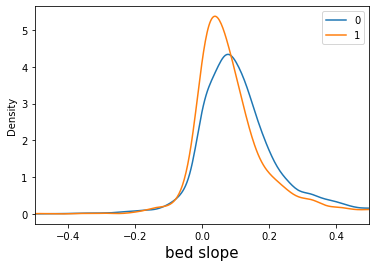

In [30]:
fig, ax = plt.subplots()

analysis_df.groupby('surgetype').bed_slope.plot.kde(ax=ax)
ax.set_xlim(-0.5, 0.5)
ax.legend()
ax.set_xlabel('bed slope', fontsize=15)

surgetype
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bed_slope, dtype: object

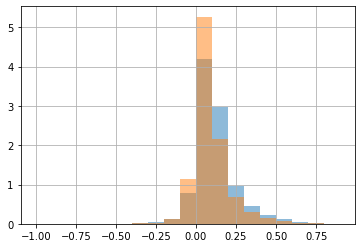

In [31]:
analysis_df.groupby('surgetype').bed_slope.hist(density=True, alpha=0.5, bins=np.arange(-1, 1, 0.1))

Text(0.5, 0, 'surface slope')

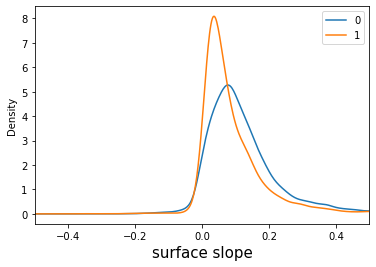

In [32]:
fig, ax = plt.subplots()

analysis_df.groupby('surgetype').surf_slope.plot.kde(ax=ax)
ax.set_xlim(-0.5, 0.5)
ax.legend()
ax.set_xlabel('surface slope', fontsize=15)

Text(0.5, 0, 'mean window thickness')

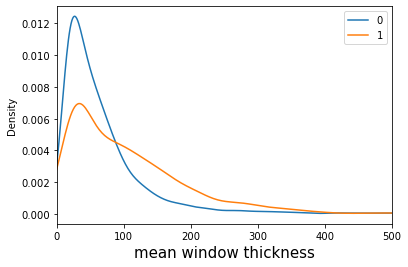

In [33]:
fig, ax = plt.subplots()

analysis_df.groupby('surgetype').thick_mean.plot.kde(ax=ax)
ax.set_xlim(0, 500)
ax.legend()
ax.set_xlabel('mean window thickness', fontsize=15)

<AxesSubplot:xlabel='thick_mean', ylabel='bed_slope'>

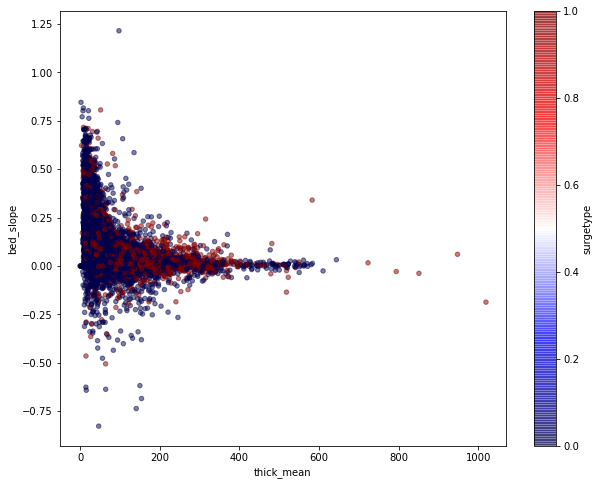

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

analysis_df.plot.scatter(x='thick_mean', y='bed_slope', c='surgetype', cmap='seismic', ax=ax, alpha=0.5)

<AxesSubplot:xlabel='surf_slope', ylabel='bed_slope'>

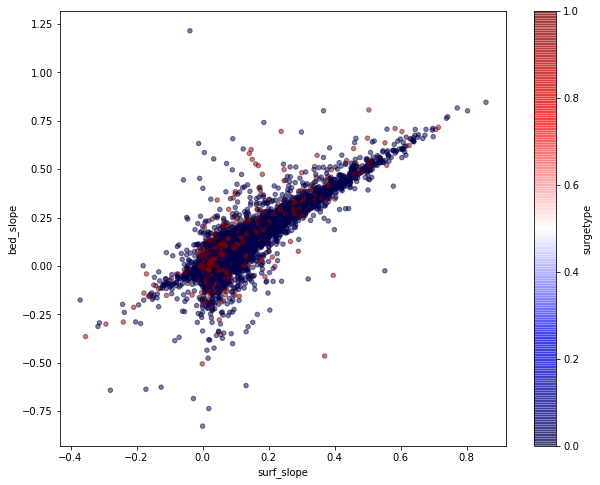

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))

analysis_df.plot.scatter(x='surf_slope', y='bed_slope', c='surgetype', cmap='seismic', ax=ax, alpha=0.5)

<AxesSubplot:xlabel='surf_slope', ylabel='thick_mean'>

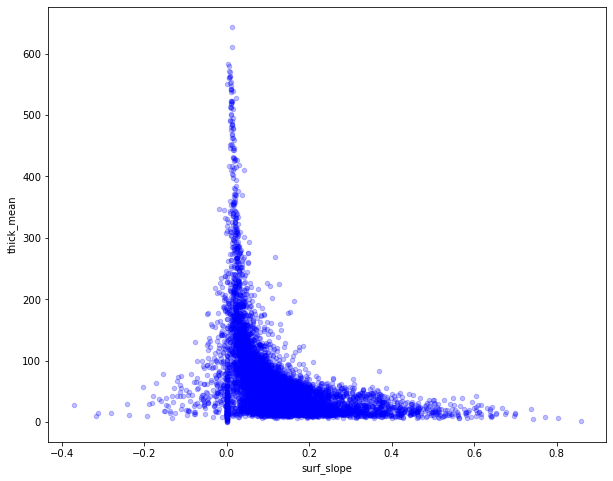

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))

analysis_df[analysis_df.surgetype==0].plot.scatter(x='surf_slope', y='thick_mean', color='blue', ax=ax, alpha=0.25)

<AxesSubplot:xlabel='surf_slope', ylabel='thick_mean'>

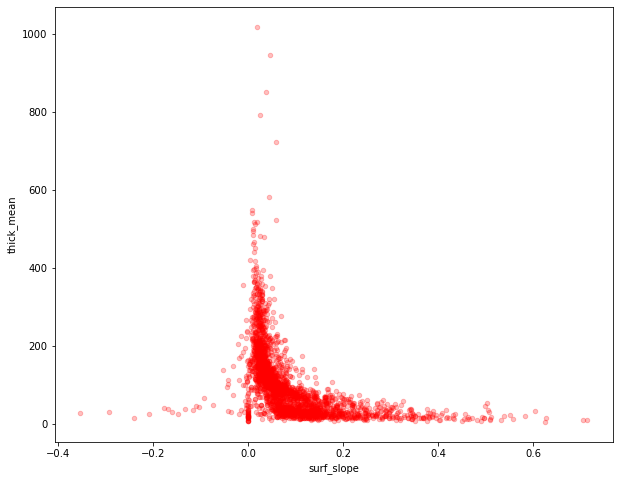

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))

analysis_df[analysis_df.surgetype==1].plot.scatter(x='surf_slope', y='thick_mean', color='red', ax=ax, alpha=0.25)

<AxesSubplot:xlabel='surf_slope', ylabel='thick_mean'>

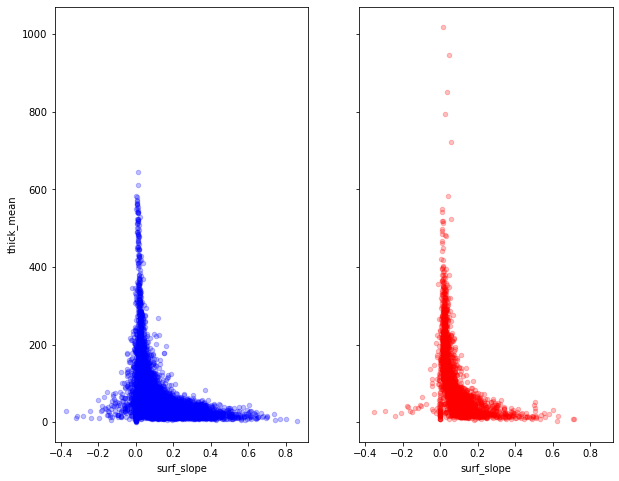

In [38]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 8), sharey=True, sharex=True)

analysis_df[analysis_df.surgetype==0].plot.scatter(x='surf_slope', y='thick_mean', color='blue', ax=ax, alpha=0.25)

analysis_df[analysis_df.surgetype==1].plot.scatter(x='surf_slope', y='thick_mean', color='red', ax=ax2, alpha=0.25)

/home/john/anaconda3/envs/framework/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  if __name__ == '__main__':
/home/john/anaconda3/envs/framework/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  del sys.path[0]


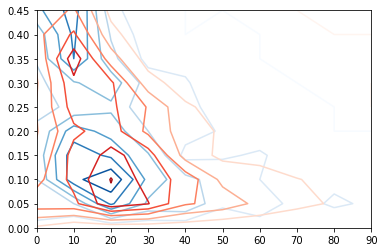

In [39]:
datasurge = analysis_df[analysis_df.surgetype==1]
datanosurge = analysis_df[analysis_df.surgetype==0]
# h, xe, ye = np.histogram2d(analysis_df.thick_mean, analysis_df.slope, bins=10, range=[[0, 100], [0, 0.5]])

fig, ax = plt.subplots()

h, xe, ye = np.histogram2d(datasurge.thick_mean, datasurge.bed_slope, bins=10, range=[[0, 100], [0, 0.5]])

ax.contour(xe[:-1], ye[:-1], h, cmap='Blues', label='surgetype')

h, xe, ye = np.histogram2d(datanosurge.thick_mean, datanosurge.bed_slope, bins=10, range=[[0, 100], [0, 0.5]])

ax.contour(xe[:-1], ye[:-1], h, cmap='Reds', label='NOT surgetype')
# ax.set_xlim(0, 10)

In [40]:
analysis_df.shape

(10493, 19)

In [41]:
# analysis_df.dropna(subset=['thick_mean', 'slope']).shape

<AxesSubplot:>

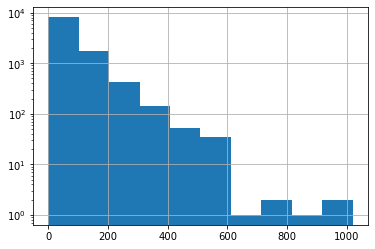

In [42]:
analysis_df.thick_mean.hist(log=True)

In [43]:
# analysis_df[['rgiid', 'surgetype']].drop_duplicates().count()

<AxesSubplot:xlabel='x', ylabel='y'>

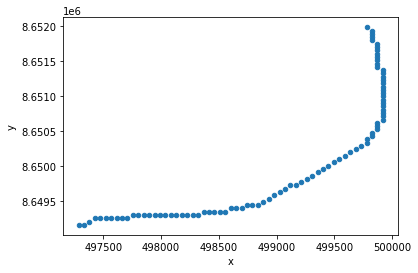

In [44]:
df[df.rgiid=='RGI60-07.01566'].plot.scatter(x='x', y='y')

In [45]:
th = analysis_df.pivot_table(index='rgiid', columns='window_id', values='thick_mean')
th.columns = ['thick_w'+str(t) for t in th.columns]

wl = analysis_df.pivot_table(index='rgiid', columns='window_id', values='window_length')
wl.columns = ['windowlength_w'+str(t) for t in wl.columns]

bs = analysis_df.pivot_table(index='rgiid', columns='window_id', values='bed_slope')
bs.columns = ['bedslope_w'+str(t) for t in bs.columns]

ss = analysis_df.pivot_table(index='rgiid', columns='window_id', values='surf_slope')
ss.columns = ['surfslope_w'+str(t) for t in ss.columns]

In [46]:
th

,thick_w0,thick_w1,thick_w2,thick_w3,thick_w4,thick_w5,thick_w6,thick_w7,thick_w8,thick_w9,thick_w10,thick_w11
rgiid,,,,,,,,,,,,
RGI60-07.00004,28.124966,33.024521,35.359421,35.605247,35.146767,32.337025,31.146065,28.473240,25.096203,20.191658,NaN,NaN
RGI60-07.00006,24.034931,41.583218,89.191566,84.318634,51.348080,45.334068,45.027786,53.622566,52.643333,46.472580,50.801445,NaN
RGI60-07.00008,26.881969,29.738972,27.283991,22.632895,19.860367,17.604805,17.312263,15.445148,14.482729,14.570744,12.777881,NaN
RGI60-07.00010,19.960442,22.366863,23.418694,21.783665,20.337429,21.572006,16.371708,15.356702,16.249269,17.168152,18.186327,NaN
RGI60-07.00024,13.757988,14.597683,12.439909,10.342457,10.829138,16.081718,18.763485,10.793846,11.094700,11.459888,11.694003,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01562,22.943802,31.091789,72.507141,78.564018,78.941040,70.506683,63.374168,55.343288,48.617020,46.996292,48.751537,NaN
RGI60-07.01563,34.055214,68.450836,70.469681,73.455521,85.295624,81.816414,70.958595,73.349625,69.521225,60.710930,NaN,NaN
RGI60-07.01564,63.128494,109.797958,104.403481,56.740112,75.952232,123.439034,176.904831,157.166794,154.651627,128.332733,90.946609,NaN


In [47]:
analysis_df.columns

Index(['window_length', 'bed_slope', 'thick_mean', 'surf_slope', 'window_id',
       'rgiid', 'Name', 'surgetype', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax'],
      dtype='object')

In [48]:
an_df = analysis_df[['rgiid', 'Name', 'surgetype', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax']].drop_duplicates().set_index('rgiid')

In [49]:
statmodel_df = an_df.join(th).join(wl).join(bs).join(ss).copy()

In [50]:
statmodel_df.columns

Index(['Name', 'surgetype', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'Area',
       'Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax', 'thick_w0',
       'thick_w1', 'thick_w2', 'thick_w3', 'thick_w4', 'thick_w5', 'thick_w6',
       'thick_w7', 'thick_w8', 'thick_w9', 'thick_w10', 'thick_w11',
       'windowlength_w0', 'windowlength_w1', 'windowlength_w2',
       'windowlength_w3', 'windowlength_w4', 'windowlength_w5',
       'windowlength_w6', 'windowlength_w7', 'windowlength_w8',
       'windowlength_w9', 'windowlength_w10', 'windowlength_w11',
       'bedslope_w0', 'bedslope_w1', 'bedslope_w2', 'bedslope_w3',
       'bedslope_w4', 'bedslope_w5', 'bedslope_w6', 'bedslope_w7',
       'bedslope_w8', 'bedslope_w9', 'bedslope_w10', 'bedslope_w11',
       'surfslope_w0', 'surfslope_w1', 'surfslope_w2', 'surfslope_w3',
       'surfslope_w4', 'surfslope_w5', 'surfslope_w6', 'surfslope_w7',
       'surfslope_w8', 'surfslope_w9', 'surfslope_w10', 'surfslope_w11'],
      dtype='object')

In [51]:
columns_for_modeling = ['surgetype', 'Area',
       'Zmin', 'Zmax', 'Zmed', 'Lmax', 'thick_w0',
       'thick_w1', 'thick_w2', 'thick_w3', 'thick_w4', 'thick_w5', 'thick_w6', 'thick_w7', 'thick_w8', 'thick_w9', 'thick_w10', 'thick_w11',
       'windowlength_w0', 'windowlength_w1', 'windowlength_w2',
       'windowlength_w3', 'windowlength_w4', 'windowlength_w5',
       'windowlength_w6', 'windowlength_w7', 'windowlength_w8',
       'windowlength_w9', 'windowlength_w10', 'windowlength_w11',
       'bedslope_w0', 'bedslope_w1', 'bedslope_w2', 'bedslope_w3',
       'bedslope_w4', 'bedslope_w5', 'bedslope_w6', 'bedslope_w7',
       'bedslope_w8', 'bedslope_w9', 'bedslope_w10', 'bedslope_w11',
       'surfslope_w0', 'surfslope_w1', 'surfslope_w2', 'surfslope_w3',
       'surfslope_w4', 'surfslope_w5', 'surfslope_w6', 'surfslope_w7',
       'surfslope_w8', 'surfslope_w9', 'surfslope_w10', 'surfslope_w11'
                       ]

In [52]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split


In [53]:
x_train, x_test, y_train, y_test = train_test_split(statmodel_df[columns_for_modeling[1:]], statmodel_df[columns_for_modeling[0]], random_state=42)

In [54]:
x_train

,Area,Zmin,Zmax,Zmed,Lmax,thick_w0,thick_w1,thick_w2,thick_w3,thick_w4,...,surfslope_w2,surfslope_w3,surfslope_w4,surfslope_w5,surfslope_w6,surfslope_w7,surfslope_w8,surfslope_w9,surfslope_w10,surfslope_w11
rgiid,,,,,,,,,,,,,,,,,,,,,
RGI60-07.00030,175.992,1,613,355,19358,520.713013,494.912567,430.861511,369.864349,331.950806,...,0.018236,0.019241,0.022831,0.026232,0.028275,0.019038,0.014562,0.023710,0.059726,NaN
RGI60-07.00587,20.345,165,947,500,7536,31.208435,36.359402,29.617794,26.980675,35.126167,...,0.125122,0.148700,0.090466,0.083815,0.105424,0.045638,0.067654,0.100588,0.125866,NaN
RGI60-07.00531,111.779,92,1015,525,22147,NaN,123.223679,187.035599,167.091187,194.136871,...,0.024106,0.036574,0.039941,0.021337,0.037867,0.038163,0.027474,0.023582,0.005828,NaN
RGI60-07.00679,2.664,71,537,283,2821,NaN,21.481419,21.551622,23.725868,30.728722,...,0.175646,0.241584,0.228931,0.172840,0.065637,0.035336,0.099140,0.088995,0.206511,NaN
RGI60-07.00532,90.645,100,1136,597,22585,80.545029,145.068909,190.212860,152.951324,135.171677,...,0.028527,0.035672,0.030022,0.046784,0.033905,0.042566,0.019948,0.026402,0.017772,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.00176,1.948,295,1129,746,2929,10.571068,10.245738,14.258488,19.613495,15.209396,...,0.607518,0.309257,0.319429,0.198591,0.073128,0.231441,0.235774,0.189325,NaN,NaN
RGI60-07.00411,17.492,165,736,494,8783,53.287830,70.397644,58.169048,38.071243,38.361691,...,0.101908,0.105155,0.080557,0.042749,0.051114,0.059897,0.044389,0.064720,0.060217,NaN
RGI60-07.01409,2.339,299,674,444,2930,15.822762,13.159531,12.914165,17.974497,16.364811,...,0.132399,-0.025792,0.047584,0.135265,0.135357,0.104381,0.097949,0.103645,0.000000,NaN


In [55]:
dmatrix_train = xgboost.DMatrix(x_train, label=y_train)
dmatrix_test = xgboost.DMatrix(x_test, label=y_test)

In [56]:
params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.3}

xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

[18:47:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [57]:
predictions = xgb.predict(dmatrix_test)

In [58]:
# pd.DataFrame({'true':y_test, 'predictions':predictions}).to_csv('bed-el-basic.csv')

In [59]:
# predictions.to_csv('bed-el-basic.csv', index=False)

In [60]:
y_test

rgiid
RGI60-07.01206    0
RGI60-07.00768    0
RGI60-07.00231    1
RGI60-07.00859    0
RGI60-07.00108    0
                 ..
RGI60-07.00804    0
RGI60-07.00512    1
RGI60-07.01378    0
RGI60-07.00045    0
RGI60-07.00140    0
Name: surgetype, Length: 246, dtype: int64

Text(0.6, 0.0, 'AUC = 0.75')

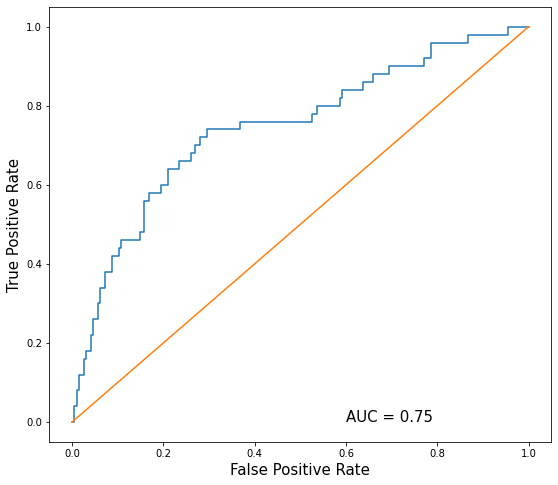

In [61]:
fpr, tpr, t = metrics.roc_curve(y_true=y_test, y_score=predictions)

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1])

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=y_test, y_score=predictions),2))
    , x=0.6, y=0.0, fontsize=15
)

(array([177.,  10.,   5.,   8.,   4.,   3.,   1.,   7.,   8.,  23.]),
 array([1.1278087e-09, 9.9997595e-02, 1.9999519e-01, 2.9999277e-01,
        3.9999038e-01, 4.9998796e-01, 5.9998554e-01, 6.9998312e-01,
        7.9998076e-01, 8.9997834e-01, 9.9997592e-01], dtype=float32),
 <BarContainer object of 10 artists>)

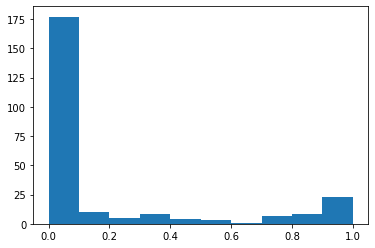

In [62]:
plt.hist(predictions)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

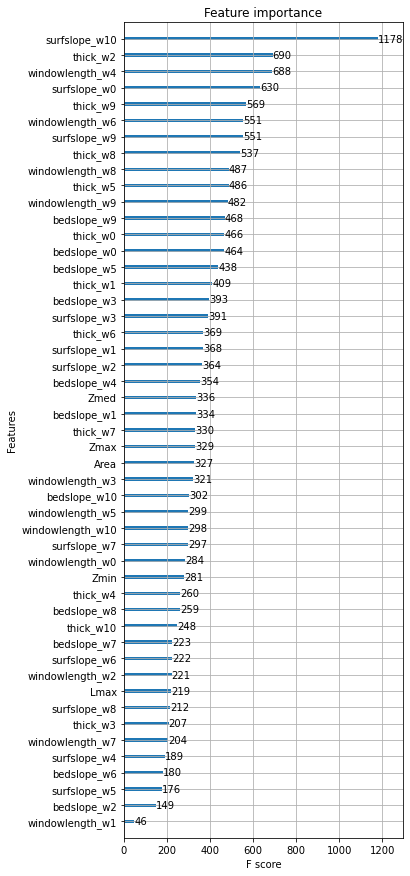

In [63]:
fig, ax = plt.subplots(figsize=(5, 15))
xgboost.plot_importance(xgb, ax=ax)

In [64]:
# analysis_df.corr()

In [65]:
# fig, ax = plt.subplots(figsize=(10, 10))

# analysis_df.plot.scatter(x='window_length', y='Lmax', ax=ax, c='surf_slope', cmap='seismic')
# ax.set_xscale('log')
# ax.set_yscale('log')

In [66]:
# data = df[df.rgiid=='RGI60-07.00004']
# lmax = data.Lmax.unique()[0]

# lmax//10

In [67]:
# data.plot.scatter(x='x', y='y')

In [68]:
# df[df.Lmax > 1000].rgiid.unique().shape

In [69]:
# plt.hist(df.groupby('rgiid').max().Lmax.values, bins=np.arange(0, 10000, 100), log=True)

In [70]:
# df[df.rgiid=='RGI60-07.00025'].Lmax

In [71]:
# fig, ax = plt.subplots()
# data.plot.scatter(x='x', y='y', ax=ax)
# ax.plot([start.x.values[0], end.x.values[0]], [start.y.values[0], end.y.values[0]], marker='*', color='red')

In [72]:
# df.dropna(subset=['thickness', 'bed']).shape

In [73]:
# data.columns

In [74]:
# data.Lmax

In [75]:
# bed = interp.griddata(XY, Z, (df.x, df.y), method='nearest')

In [76]:
# import timeit
# start = timeit.default_timer()
# # print(interp.griddata(XY, Z, (XY[~np.isnan(Z)][0][0], XY[~np.isnan(Z)][0][1]), method='nearest'))
# print(interp.griddata(XY, Z, (df.x.iloc[:10], df.y.iloc[:10]), method='nearest'))
# stop = timeit.default_timer()
# print('Time: ', stop - start) 

In [77]:
# start = timeit.default_timer()
# print(interp.griddata(XY, Z, (df.x.iloc[:10], df.y.iloc[:10]), method='nearest'))
# stop = timeit.default_timer()
# print('Time: ', stop - start) 

In [78]:
# start = timeit.default_timer()
# print(interp.griddata(XY, Z, (df.x.iloc[:100], df.y.iloc[:100]), method='nearest'))
# stop = timeit.default_timer()
# print('Time: ', stop - start)